
##Low Light Image Enhancement


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q '/content/gdrive/MyDrive/Train.zip'

In [7]:
import numpy as np
import cv2
import imageio
import glob
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage

##Loading our dataset images.


---


In [ ]:
path = r'/content/Train/high'
all_files = glob.glob(path + "/*.png")
high = list()
all_files.sort()
for fileName in all_files:
        img = imageio.imread(fileName)
        high.append(img)
high = np.array(high)

path = r'/content/Train/low'
all_files = glob.glob(path + "/*.png")
all_files.sort()
low = list()
for fileName in all_files:
        img = imageio.imread(fileName)
        low.append(img)
low = np.array(low)

<ipython-input-4-7fd97c93aaf7>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fileName)
<ipython-input-4-7fd97c93aaf7>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fileName)


In [ ]:
!rm -rf '/content/Train/low/.DS_Store'
!rm -rf '/content/Train/high/.DS_Store'

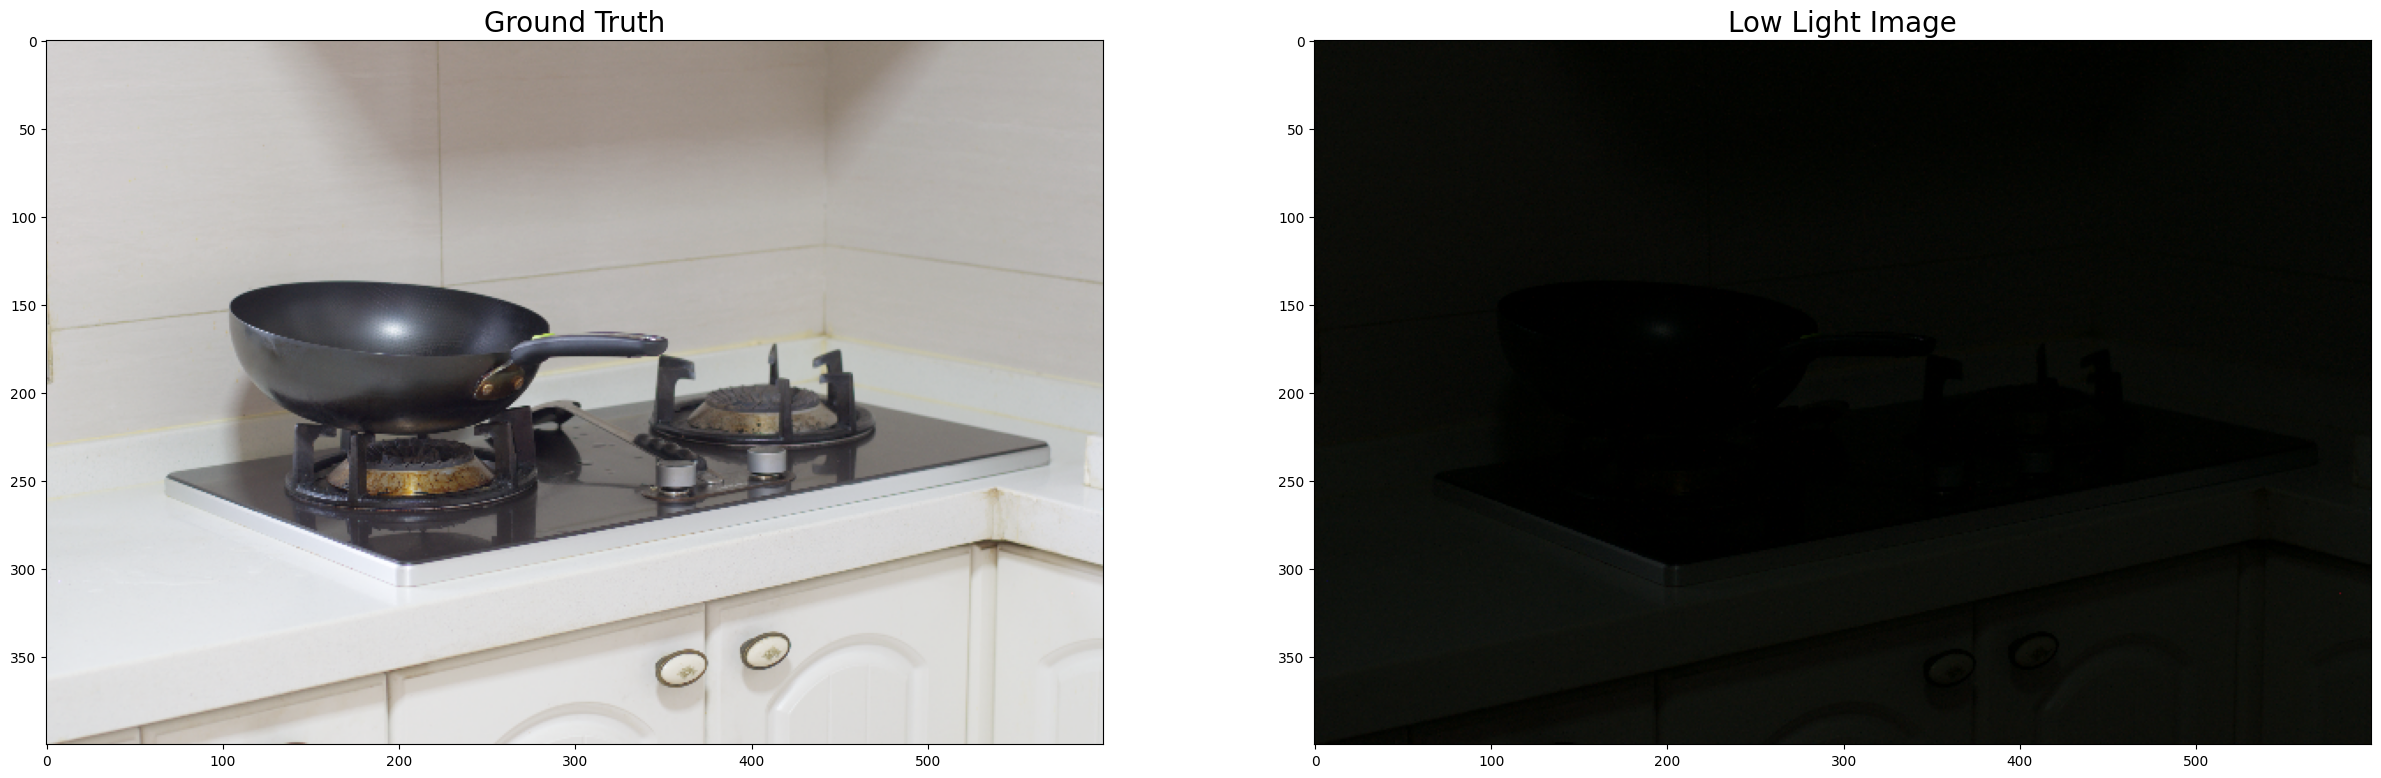

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.title("Ground Truth",fontsize=20)
plt.imshow(high[479])

plt.subplot(1,2,2)
plt.title("Low Light Image",fontsize=20)
plt.imshow(low[479])

##Model

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [4]:
activation = 'relu'
Padding = 'same'
strides=(1,1)
kernel = (3,3)
inputs = keras.Input(shape=(None, None, 3), name='img')

In [5]:
# Creating model

layer1 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(inputs)

layer2 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer1)

layer3 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer2)

layer4 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer3)

layer5 = layers.add([layer3, layer4]) # Combination of 2 layers

layer6 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer5)

layer7 = layers.add([layer2, layer6]) # combination of 2 layers

layer8 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer7)

final = layers.add([layer1, layer8])

# For output we will use sigmoid activation for values between [0,1]
outLayer = layers.Conv2D(1, kernel, activation='sigmoid', padding=Padding)(final)

denoisingModel = keras.Model(inputs, outLayer)

2024-06-10 15:07:45.310268: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-10 15:07:45.310303: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-10 15:07:45.310313: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-10 15:07:45.310819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 15:07:45.311371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
denoisingModel.compile(optimizer="adam", loss='mean_squared_error', metrics=[psnr_metric])

### Training the model

---



In [ ]:
import numpy as np

def GenerateInputs(X, y):
    for i in range(len(X)):
        X_input = X[i].reshape(1, 400, 600, 3)
        y_temp = y[i] / 255
        if y_temp.shape[-1] == 1:
            y_temp = np.repeat(y_temp, 3, axis=-1)  # Converting grayscale to RGB by repeating the channel
        y_input = y_temp.reshape(1, 400, 600, 3)
        yield (X_input, y_input[:, :, :, 0:1])  # Ensuring that y_input has a single channel

denoisingModel.fit(GenerateInputs(low, high), epochs=22, verbose=1, steps_per_epoch=22)  # This epoch number after testing

### Saving the trained model

---



In [ ]:
denoisingModel.save(r'/content/gdrive/MyDrive/mymodel2.h5')

## Testing


---

In [ ]:
import glob
path = r'/Users/dikshitrishi/WorkWork/Denoising/Data/low'
all_files = glob.glob(path + "/*")
x = list()
all_files.sort()
for fileName in all_files:
        img = imageio.imread(fileName)
        x.append(img)
X = np.array(x)

/var/folders/x2/5r0bd8ys3tg76zfjx6x9pvmh0000gn/T/ipykernel_40389/1001851651.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fileName)


##Loading model

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

model = load_model('/Users/dikshitrishi/Downloads/mymodel2.h5', custom_objects={'psnr_metric': psnr_metric})


In [ ]:
import tensorflow as tf

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def Enhance(img, index, flag):
    if index == 0:
        return img

    elif flag == 1:
        h, w, c = img.shape
        test = model.predict(img.reshape(1, h, w, 3))
        temp = img / 255
        image = temp + ((test[0,:,:,:] * temp)*(1-temp))
        psnr_value = psnr_metric(tf.convert_to_tensor(img, dtype=tf.float32), tf.convert_to_tensor(image * 255, dtype=tf.float32)).numpy()
        print(f"PSNR: {psnr_value:.4f}")
        index = index - 1
        flag = 0
        return Enhance(image, index, flag)

    else:
        h, w, c = img.shape
        temp = model.predict(img.reshape(1, h, w, 3))
        image = img + ((temp[0,:,:,:] * img)*(1-img))
        psnr_value = psnr_metric(tf.convert_to_tensor(img, dtype=tf.float32), tf.convert_to_tensor(image, dtype=tf.float32)).numpy()
        print(f"PSNR: {psnr_value:.4f}")
        index = index - 1
        return Enhance(image, index, flag)

###**Examples**

---



2024-06-08 15:14:46.674647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 709ms/step
PSNR: -20.1523
1/1 [==============================] - 0s 62ms/step
PSNR: 33.2381
1/1 [==============================] - 0s 12ms/step
PSNR: 31.7561
1/1 [==============================] - 0s 12ms/step
PSNR: 30.4430
1/1 [==============================] - 0s 12ms/step
PSNR: 29.3278
1/1 [==============================] - 0s 12ms/step
PSNR: 28.4424
1/1 [==============================] - 0s 12ms/step
PSNR: 27.8121
1/1 [==============================] - 0s 12ms/step
PSNR: 27.4463


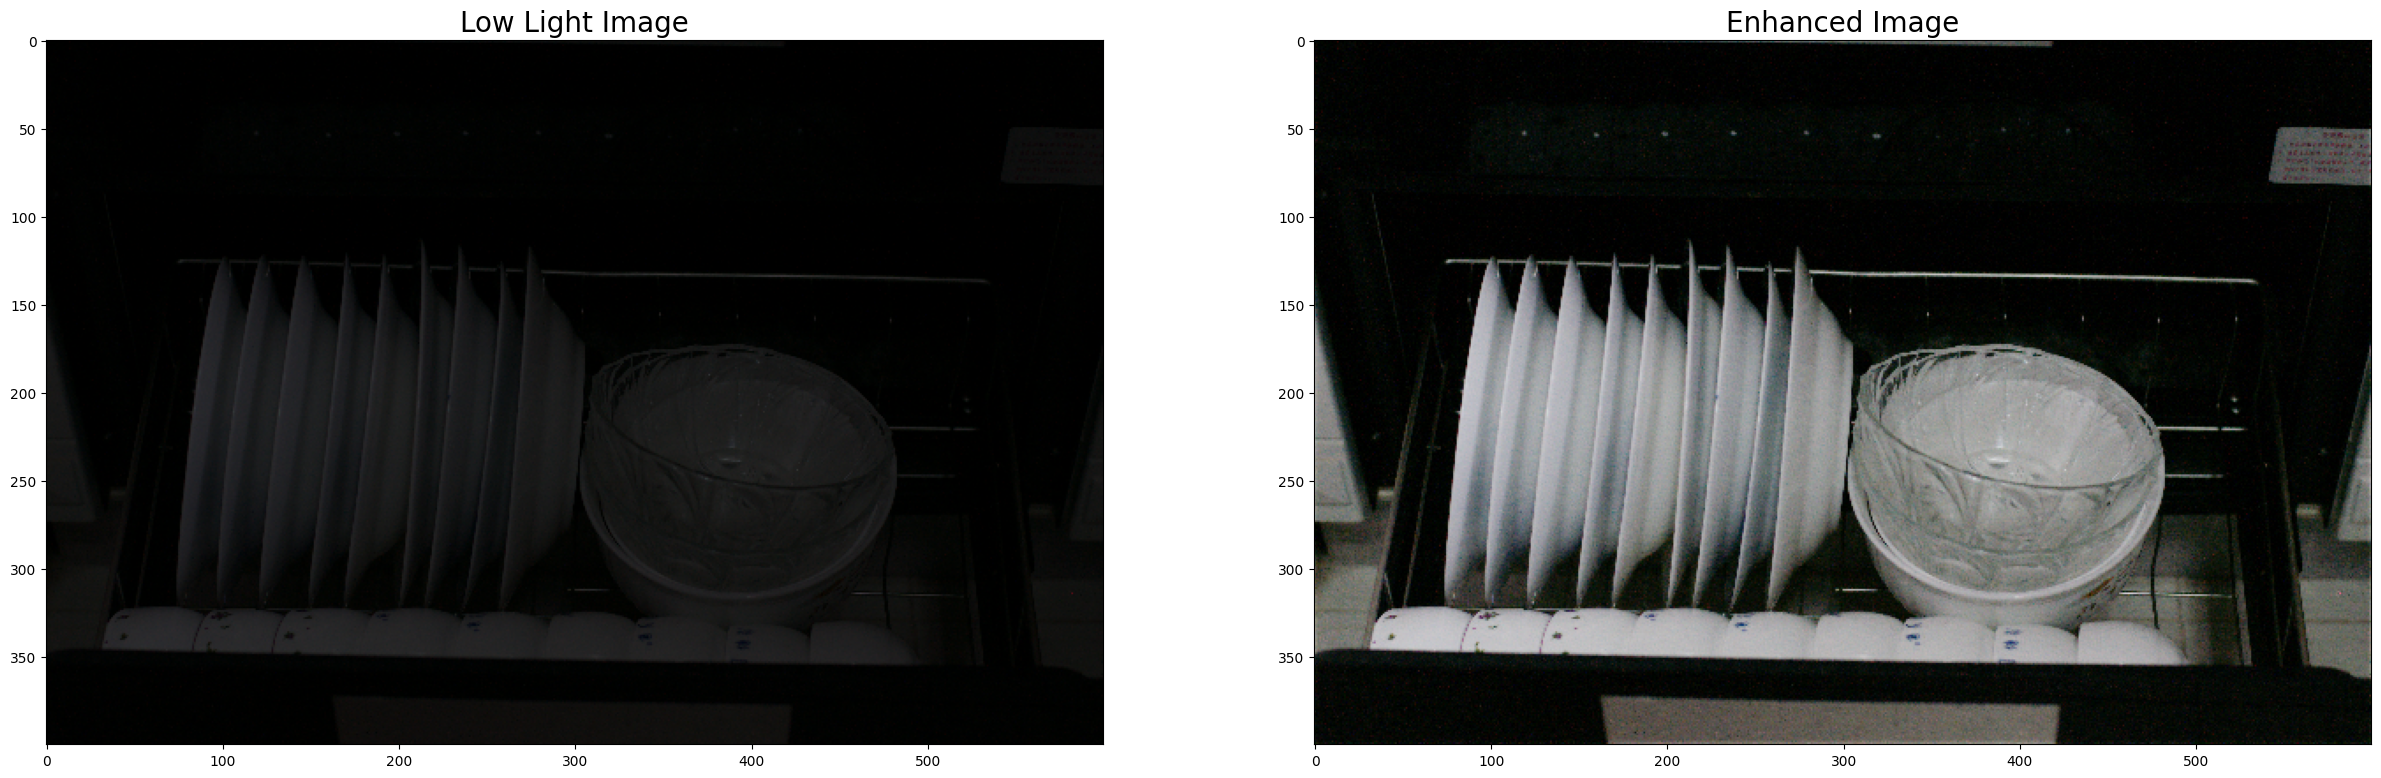

In [ ]:
Image = X[1]
plt.figure(figsize=(30,30))

plt.subplot(1,2,1)
plt.title("Low Light Image",fontsize=20)
plt.imshow(Image)

plt.subplot(1,2,2)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(Enhance(Image, 8, 1))

1/1 [==============================] - 0s 17ms/step
PSNR: -23.6585
1/1 [==============================] - 0s 13ms/step
PSNR: 29.6808
1/1 [==============================] - 0s 12ms/step
PSNR: 28.1740
1/1 [==============================] - 0s 12ms/step
PSNR: 26.8349
1/1 [==============================] - 0s 12ms/step
PSNR: 25.6964
1/1 [==============================] - 0s 12ms/step
PSNR: 24.7799
1/1 [==============================] - 0s 13ms/step
PSNR: 24.1146
1/1 [==============================] - 0s 13ms/step
PSNR: 23.7154


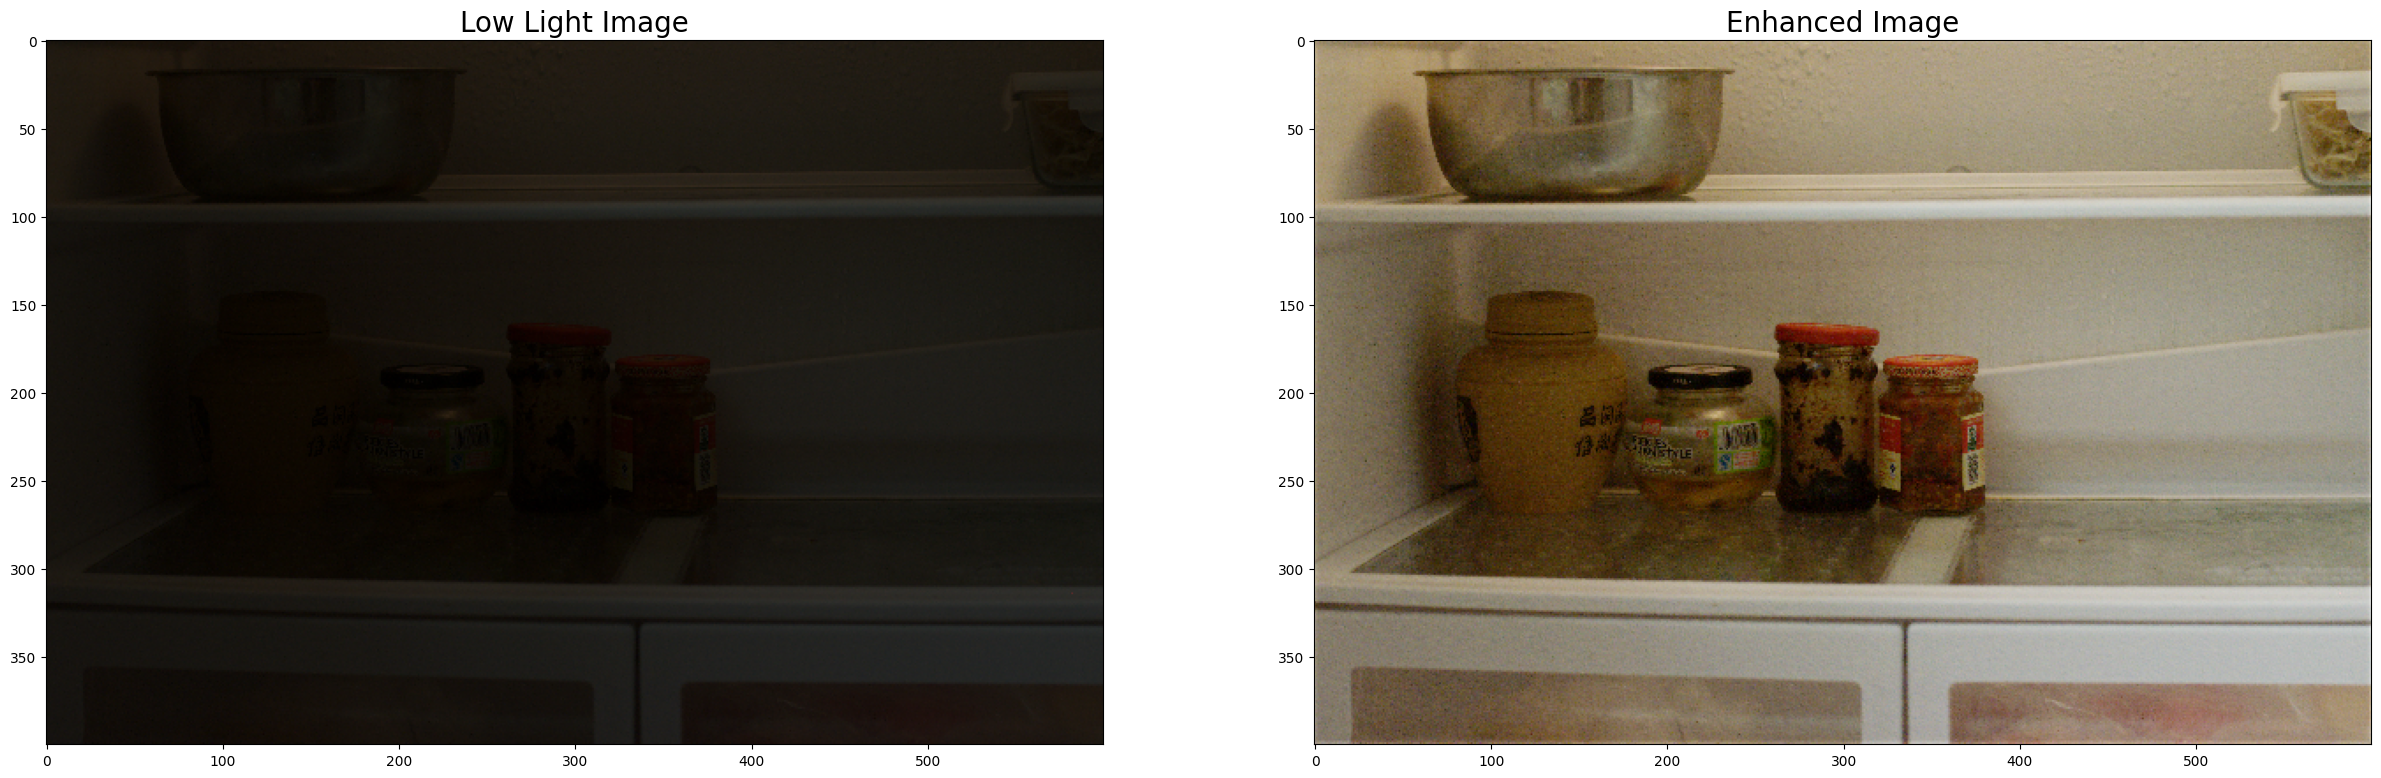

In [ ]:
Image = X[18]

plt.figure(figsize=(30,30))

plt.subplot(1,2,1)
plt.title("Low Light Image",fontsize=20)
plt.imshow(Image)

plt.subplot(1,2,2)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(Enhance(Image, 8, 1))

1/1 [==============================] - 0s 24ms/step
PSNR: -26.4122
1/1 [==============================] - 0s 13ms/step
PSNR: 27.2575
1/1 [==============================] - 0s 23ms/step
PSNR: 25.9790
1/1 [==============================] - 0s 12ms/step
PSNR: 24.9065
1/1 [==============================] - 0s 12ms/step
PSNR: 24.1150
1/1 [==============================] - 0s 12ms/step
PSNR: 23.6431
1/1 [==============================] - 0s 12ms/step
PSNR: 23.4727
1/1 [==============================] - 0s 12ms/step
PSNR: 23.5944
1/1 [==============================] - 0s 12ms/step
PSNR: 24.0102
1/1 [==============================] - 0s 12ms/step
PSNR: 24.6933
1/1 [==============================] - 0s 13ms/step
PSNR: 25.6053
1/1 [==============================] - 0s 12ms/step
PSNR: 26.7145


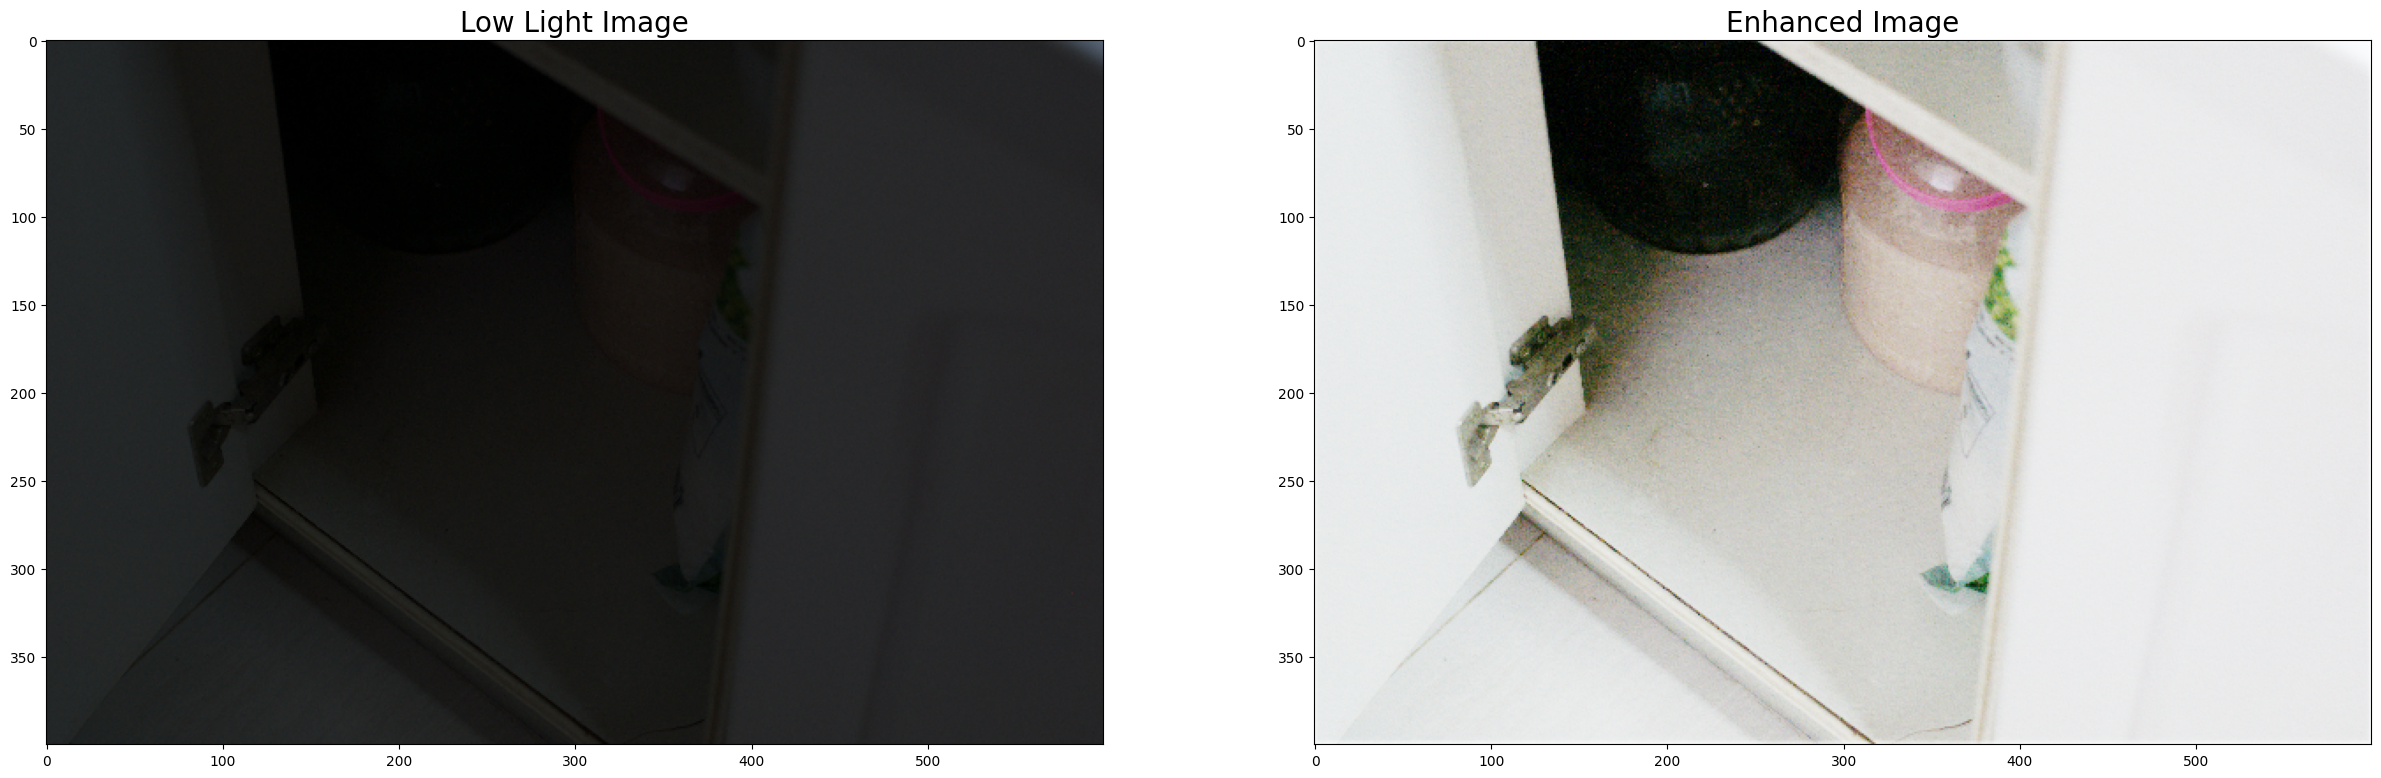

In [ ]:
Image = X[9]

plt.figure(figsize=(30,30))

plt.subplot(1,2,1)
plt.title("Low Light Image",fontsize=20)
plt.imshow(Image)

plt.subplot(1,2,2)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(Enhance(Image, 12, 1))